# Weekly Reversals

- information coefficient, slippage, cross-sectional dispersion
- structural breaks, unknown changepoint
- rpy2, CRSP, Wharton Research Data Services

Terence Lim

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from finds.database import SQL, Redis
from finds.structured import CRSP
from finds.busday import BusDay, Weekly
from settings import settings
sql = SQL(**settings['sql'])
user = SQL(**settings['user'])
rdb = Redis(**settings['redis'])
bd = BusDay(sql)
crsp = CRSP(sql, bd, rdb)
logdir = os.path.join(settings['images'], 'weekrev')

## Custom weekly trading day calendar
- select Friday end

In [2]:
rebalbeg = 19730629  # increased stocks coverage in CRSP from around this date
rebalend = 20210101  # a Friday, so can include last week in 2020
wd = Weekly(sql, 'Fri', rebalbeg, rebalend) # Generate Friday-end weekly calendar

## Retrieve weekly returns, standardize scores, and compute returns and i.c.

In [3]:
june_universe = 0   # to track when reached a June end to update universe
year = 0            # to track new year to retrieve prices in batch for screening
res = DataFrame()
tic = time.time()
for rebaldate in wd.date_range(rebalbeg, rebalend)[:-1]:
    d = bd.june_universe(rebaldate)        
    if d != june_universe:
        june_universe = d                        # update universe every June-end
        univ = crsp.get_universe(june_universe)  # usual CRSP universe screen
        univ = univ[univ['decile'] < 10]         # drop smalest decile stocks
    start = wd.begwk(rebaldate)     # starting date of rebalance week
    beg = bd.offset(rebaldate, 1)   # beginning date of holding week
    end = wd.endwk(beg)             # ending date of holding week

    prcdate = bd.offset(start,-1)   # require price available at start of week
    prcyear = (prcdate // 10000) * 10000 
    if prcyear != year:    # retrieve new batch of prices each new year
        year = prcyear 
        prc = crsp.get_range('daily', 'prc', 'date', year+101, year+1231,
                             use_cache=True)
    X = prc[prc.index.get_level_values('date') == prcdate]\
        .reset_index()\
        .set_index('permno')\
        .join(crsp.get_ret(start,rebaldate).reindex(univ.index))\
        .dropna()   # retrieve prior week's returns, require start price
    Y = crsp.get_ret(beg, end).reindex(X.index).fillna(0)  # gross return
    Z = crsp.get_ret(bd.offset(beg, 1), end).reindex(X.index).fillna(0) # net ret

    z = Z['ret']
    y = Y['ret']
    x = (X['ret'].mean() - X['ret'])/(X['ret'].std(ddof=0)*len(X)) # standardize
    res = res.append(DataFrame({'ret': x.dot(y),
                                'ic': x.corr(y),
                                'n': len(Y),
                                'vol': y.std(ddof=0),
                                'net': x.dot(z)}, index=[rebaldate]))

## Compute gross and net annualized sharpe ratios

In [4]:
DataFrame({'Sharpe': np.sqrt(52)*res['ret'].mean()/res['ret'].std(),
           'Net Sharpe': np.sqrt(52)*res['net'].mean()/res['ret'].std(),
           'Total Return': res['ret'].mean(),
           'Net Return': res['net'].mean(),
           'Information Coefficient': res['ic'].mean(),
           'Cross-sectional Vol': res['vol'].mean()},
          index=[min(res.index.astype(str)) + ':' + max(res.index.astype(str))])

,Sharpe,Net Sharpe,Total Return,Net Return,Information Coefficient,Cross-sectional Vol
19730706:20201224,2.591748,2.217857,0.002525,0.002161,0.042005,0.057823


## Plot returns, i.c. and cross-sectional vol over time

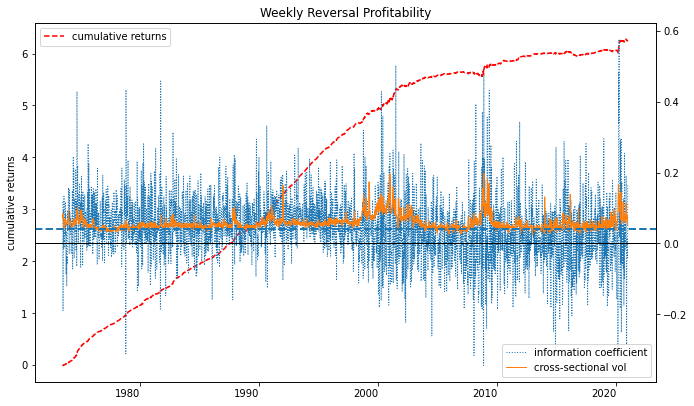

In [5]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
res.index = pd.DatetimeIndex(res.index.astype(str))
res['ret'].cumsum().plot(ax=ax, ls='--', color='r', rot=0)
ax.legend(['cumulative returns'], loc='upper left')
ax.set_ylabel('cumulative returns')
bx = ax.twinx()
res['ic'].plot(ax=bx, ls=':', lw=1, rot=0)
res['vol'].plot(ax=bx, ls='-', lw=1, rot=0)
bx.axhline(res['ic'].mean(), linestyle='--', color='C0', lw=2)
bx.axhline(0, linestyle='-', color='black', lw=1)
bx.legend(['information coefficient', 'cross-sectional vol'], loc='lower right')
ax.set_title('Weekly Reversal Profitability')
plt.tight_layout(pad=2)
plt.savefig(os.path.join(logdir, 'weekrev.jpg'))

# Structural Break Test with Unknown Changepoint Date

In [7]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.pyR import PyR, savepng
importr('strucchange')
Y = res['ret']
X = pd.DatetimeIndex(res.index.astype(str)).to_numpy()  # x-axis as datetime
formula = ro.Formula('y ~ 1')
formula.environment['y'] = PyR(Y.values).ro
breakpoints = ro.r['breakpoints'](formula)         # candidate breakpoints
confint = ro.r['confint'](breakpoints, breaks=1)   # conf interval for 1 break
fs = ro.r['Fstats'](formula, **{'from': 0.15})     # F-stats for all points
sc = ro.r['sctest'](fs, **{'type': 'aveF'})        # aveF-test for break point
out = PyR(confint[0]).frame.iloc[0].astype(int)-1  # adjust R's starting index
out.iloc[:] = X[out.iloc[:].astype(int)]
out = out.append(Series({k: PyR(v).values[0] for k,v in 
                         zip(sc.slots['names'][:3], sc[:3])}))
out = out.append(Series({'mean(pre)': Y[X <= out.iloc[1]].mean(),
                         'mean(post)': Y[X > out.iloc[1]].mean()}))
out.rename('changepoint').to_frame().T

PyR: ndarray (2478,) <class 'numpy.ndarray'>
PyR: ndarray (1, 3) <class 'rpy2.robjects.vectors.FloatMatrix'>
PyR: ndarray (1,) <class 'rpy2.robjects.vectors.FloatVector'>
PyR: ndarray (1,) <class 'rpy2.robjects.vectors.FloatVector'>
PyR: ndarray (1,) <class 'rpy2.robjects.vectors.StrVector'>


,2.5 %,breakpoints,97.5 %,statistic,p.value,method,mean(pre),mean(post)
changepoint,2000-01-07,2001-12-28,2002-11-15,41.48704,0.0,aveF test,0.003626,0.000872


# Plot F-statistics and breakpoint confidence intervals

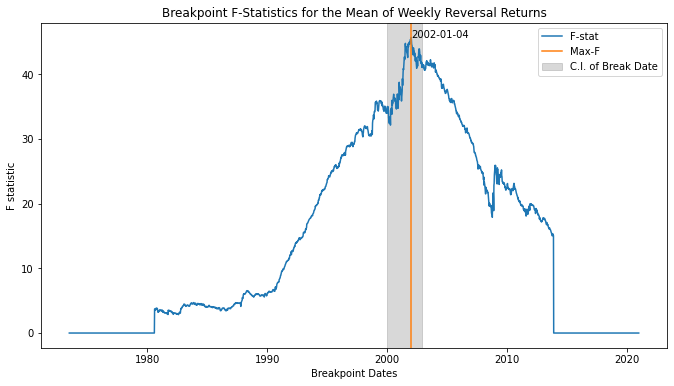

In [11]:
def fstats(x, tail=0.15):
    """Helper to compute F-stats at all candidate break points"""
    n = len(x)
    rse = np.array(np.var(x, ddof=0))
    sse = np.ones(n) * rse
    for i in range(int(n * tail), int((1-tail) * n)+1):
        sse[i] = (np.var(x[:i], ddof=0)*i + np.var(x[i:], ddof=0)*(n-i))/n
    return ((n-2)/2) * (rse - sse)/rse
sse = fstats(Y)         # F-statistic at all break point dates
confint = out.iloc[:3]  # confidence interval from aveF structurel change test
fig, ax = plt.subplots(num=2, clear=True, figsize=(10,6))
ax.plot(X, sse, color='C0')
argmax = np.nanargmax(sse)
ax.axvline(X[argmax], color='C1')
ax.axvspan(confint[0], confint[2], alpha=0.3, color='grey')
ax.legend(['F-stat', 'Max-F', 'C.I. of Break Date'])
ax.annotate(str(X[argmax])[:10], xy=(X[argmax], sse[argmax]))
ax.set_ylabel('F statistic')
ax.set_xlabel('Breakpoint Dates')
ax.set_title('Breakpoint F-Statistics for the Mean of Weekly Reversal Returns')
plt.tight_layout(pad=3)
plt.savefig(os.path.join(logdir, 'break.jpg'))